In [2]:
# Titanic Problem using Fastai

# Importing the libraries
import numpy as np
import pandas as pd
import torch
from torch import nn
from fastai.tabular.all import *

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
# Torch Version
print(f"Torch Version: {torch.__version__}")

# Device Agonistic Code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Torch Version: 2.0.0+cpu
Device: cpu


In [4]:
# Reading train data

train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [6]:
# Data Preprocessing

def cleanDF(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp + df.Parch
    df['Alone'] = df.Family == 0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr", Miss="Miss", Mrs="Mrs", Master="Master"))
    
cleanDF(train_df)

In [7]:
# Train/Test Split
splits = RandomSplitter(seed=42)(train_df)

In [8]:
# Dataloader

dls = TabularPandas(
    train_df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names = ["Sex", "Pclass", "Embarked", "Deck", "Title"],
    cont_names = ["Age", "SibSp", "Parch", "LogFare", "Alone", "TicketFreq", "Family"],
    y_names = "Survived", y_block = CategoryBlock(),
).dataloaders(path = ".")

SuggestedLRs(slide=0.0831763744354248, valley=0.0063095735386013985)

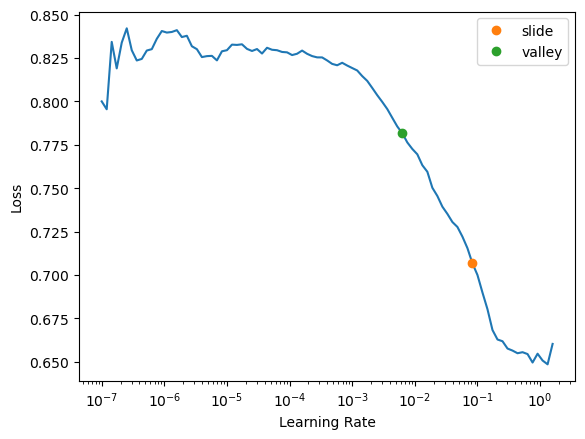

In [9]:
# Training the model

learn = tabular_learner(dls, metrics=accuracy, layers=[16, 16])
learn.lr_find(suggest_funcs=(slide, valley))

In [10]:
epochs = 20
learn.fit(epochs, lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.562634,0.568324,0.786517,00:00
1,0.502291,0.521942,0.814607,00:00
2,0.473611,0.430615,0.792135,00:00
3,0.448313,0.439096,0.820225,00:00
4,0.433355,0.435877,0.842697,00:00
5,0.424351,0.415807,0.814607,00:00
6,0.413617,0.417784,0.825843,00:00
7,0.408640,0.421635,0.820225,00:00
8,0.405577,0.418532,0.814607,00:00
9,0.401124,0.413307,0.808989,00:00


In [12]:
# Submission to Kaggle

test_df['Fare'] = test_df.Fare.fillna(0)
cleanDF(test_df)

In [13]:
# Dataloader for test dataframe
testDL = learn.dls.test_dl(test_df)

# Predictions for the test set
preds,_ = learn.get_preds(dl=testDL)

In [15]:
# Submisison file
test_df['Survived'] = (preds[:,1]>0.5).int()

# Submission dataframe
sub_df = test_df[['PassengerId', 'Survived']]
sub_df.to_csv('submission.csv', index=False)

In [16]:
!head submission.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
